Imports iniciales:

In [23]:
!pip install scikit-optimize  --quiet
!pip install apafib --upgrade  --quiet
!pip install wordcloud --upgrade --quiet

In [24]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

Fijar la seed del generador de numeros aleatorios que usa torch

In [25]:
torch.manual_seed(33)

if torch.cuda.is_available():
    torch.cuda.manual_seed(33)
    torch.cuda.manual_seed_all(33)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [26]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [27]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from apafib import load_arxiv, load_energy

from skopt import BayesSearchCV
np.int = int # fix for skopt

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [28]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'train XV acc'] = clf.best_score_
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

Funciones útiles para nuestro ejercicio:

In [29]:
# Clase para generar un dataset a patir de las matrices de datos y etiquetas
class miniMNIST(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data).float()
        self.labels = torch.Tensor(labels).long()
        self.n_classes = len(np.unique(labels))

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, F.one_hot(y, self.n_classes).float()

    def __len__(self):
        return len(self.data)

# Generar el data loader
# MNIST = torch.utils.data.DataLoader(miniMNIST(train, labels), batch_size=32)

In [30]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, patience=5, epochs=100):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenal
        train: datos de entrenamiento
        val: datos de validacion
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cpu')
            y = labels.to('cpu')
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, y, reduction="mean")
            data_loss += loss.item()
        return data_loss / i

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > val_loss[-(patience+1)]:
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cpu')
            y = labels.to('cpu')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = F.cross_entropy(outputs, y, reduction="mean")

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion

        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})
        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break
    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

In [31]:
# Clase para definir la arquitectura del MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers_sizes, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(nn.Linear(hidden_layers_sizes[i-1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        self.output = nn.Linear(hidden_layers_sizes[-1], num_classes)

    def forward(self, x):
        return self.output(self.layers(x))

In [32]:
# Clase para definir la arquitectura de la red convolucional
class convolutional(nn.Module):
    def __init__(self, num_classes=5, kernels=[16,32], activation=nn.ReLU):
        super(convolutional, self).__init__()
        self.convo1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convo2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*kernels[1], num_classes)

    def forward(self, x):
        out = self.convo2(self.convo1(x.view(x.size(0), 1, 28, 28)))
        return self.fc(out.reshape(out.size(0), -1))

In [33]:
def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion

    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _etiquetas predichas, etiquetas reales_
    """
    preds = []
    true = []
    for i, (data, labels) in enumerate(test):
        inputs = data.to('cpu')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(labels.detach().cpu().numpy())
    return np.argmax(np.concatenate(preds), axis=1), np.argmax(np.concatenate(true), axis=1)

# Lista 3 Problema 1: ¿Qué número es este?

Parece haber una obsesión con conjuntos de datos que representan dígitos escritos a mano. Esto tiene una explicación sencilla. Uno de los primeros retos del OCR fue el reconocimiento de códigos postales en cartas. El clasificar cartas a mano consume demasiado tiempo y no es completamente fiable (además de ser muy aburrido), por lo que tener un sistema eficiente para clasificar el correo era un problema interesante. Uno de los conjuntos de datos más conocido es MNIST digits. Vamos a utilizar una parte de este conjunto de datos, en concreto un subconjunto de los dígitos 3, 5, 6, 8 y 9, para experimentar con diferentes redes neuronales. Podéis obtenerlos mediante la función load_MNIST de la librería apafib. Esta función retornará cuatro matrices de datos, el conjunto de entrenamiento, el conjunto de test y las etiquetas de los dos. Resolved los siguientes apartados ilustrando los resultados de la manera que os parezca más adecuada.

## Cargamos los datos

In [34]:
from apafib import load_MNIST

# La función devuelve los conjuntos de entrenamiento y test, así como sus respectivos labels
train_data, test_data, train_lbl, test_lbl = load_MNIST()

Nuestros datos ya se encuentran divididos en conjuntos, por lo que no será necesario realizar splits. Además, la normalización ya viene realizada de serie (valores de 0 a 1), por lo que durante el preprocesado nos tendremos que centrar únicamente en transformar estas imágenes a matrices de datos. Usaremos para esto las funciones que nos han sido proporcionadas.

In [35]:
train_df = torch.utils.data.DataLoader(miniMNIST(train_data, train_lbl), batch_size=32)
test_df = torch.utils.data.DataLoader(miniMNIST(test_data, test_lbl), batch_size=32)

miniMNIST nos devuelve un iterador del dataframe en secciones. Si queremos ver todos los puntos en un plot 2D, los concatenaremos en un único dataframe.

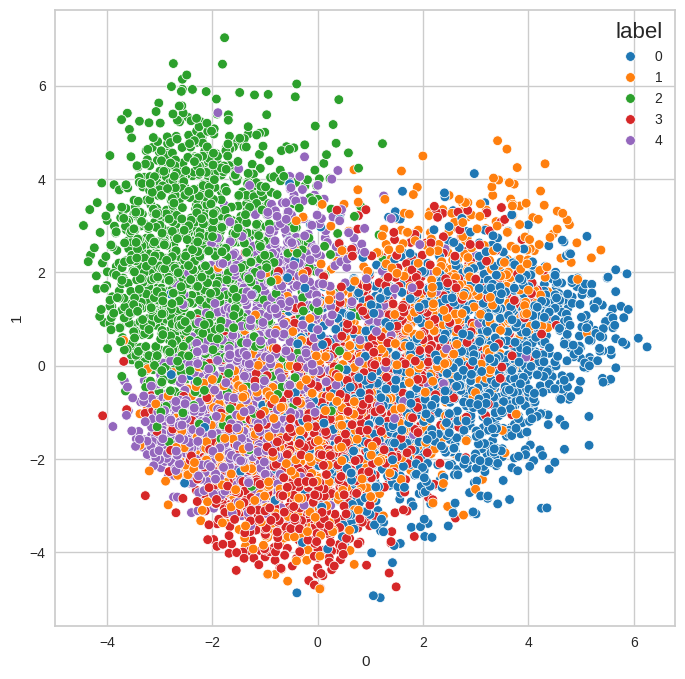

In [36]:
all_X_train = []
all_y_train = []

for X_split, y_split in train_df:
    all_X_train.append(X_split)
    all_y_train.append(torch.argmax(y_split, axis=1))

all_X_train = torch.cat(all_X_train, dim=0)
all_y_train = torch.cat(all_y_train, dim=0)

all_X_train = all_X_train.numpy()
all_y_train = all_y_train.numpy()

pca = PCA()
tdata = pca.fit_transform(np.asarray(all_X_train))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':all_y_train})],axis=1)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

Vemos una separación decente entre clases, especialmente para la clase 2. La clase 4 también tiene una buena distinción con el resto y, aunque se sobrepone ligeramente con otras clases, no ocurre lo suficiente para considerarse problemático.
La clase 0 consigue diferenciarse por el extremo derecho del conjunto de datos, pero en su aproximación al centro pierde diferenciación debido al cúmulo formado por las clases 1 y 3, que son casi indistiguibles entre sí debido a ocupar la misma porción de espacio.

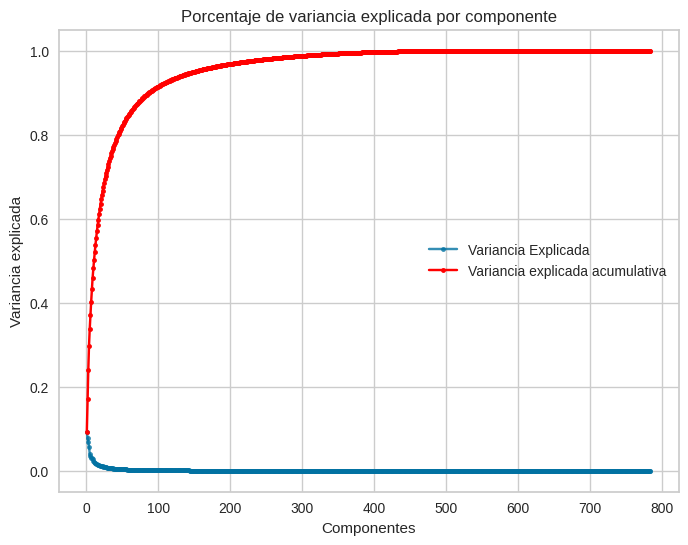

In [37]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Evidentemente, el número de componentes es demasiado elevado para considerar PCA una opción dentro de este problema.

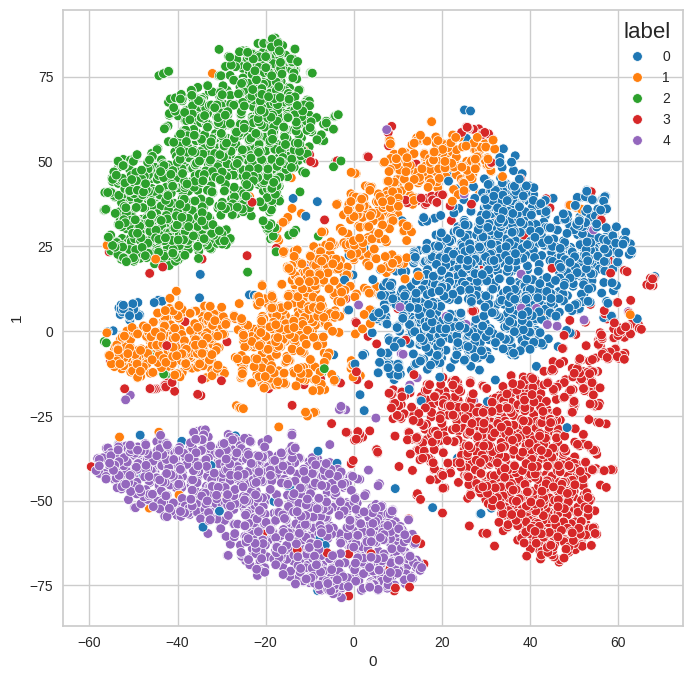

In [38]:
tsne = TSNE(init='pca')
tdata = tsne.fit_transform(np.asarray(all_X_train))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':all_y_train})],axis=1);
fig = plt.figure(figsize=(8,8));
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

A diferencia de PCA, t-SNE genera varios clusters bien diferenciados entre sí que, si bien presentan ciertos puntos incorrectamente situados entre medio de dos o tres clusters, este número es pírrico en comparación a la excelente separabilidad que obtenemos.

### Apartado B
Comenzaremos por obtener un valor de acierto base. Asumiendo que los píxeles son in-
dependientes y se distribuyen de manera Multinomial (solo hay 16 valores distintos en
los datos). Ajustad un modelo Naïve Bayes Multinomial. Evaluad la calidad del modelo y
comentad los resultados.

### Apartado C
Ahora aplicaremos un MLP a estos datos. En el código del notebook tenéis una función que permite generar modelos MLP variando el número de capas y la función de activación. La red se define como una clase python donde en el método __init__ definimos los elementos de la red y en el forward cómo se hace la propagación hacia adelante en la red (la propagación hacia atrás se calcula automáticamente).

Para pasarle los datos a un modelo de torch hay que definir una clase del tipo Dataset, tenéis una definida en el notebook a la que hay que pasarle la matriz de datos y el vector con las etiquetas. Esta clase se ha de pasar a un objeto Dataloader que se encarga de organizar el uso de los datos durante el entrenamiento, entre otras cosas de partir los datos en grupos (batch_size), podéis ver un ejemplo en el notebook.

Para entrenar los modelos usaremos la función train_loop que tenéis en el notebook. Esta función recibe el modelo, el optimizador a usar, los datos de entrenamiento y validación y el número de iteraciones que hará el entrenamiento. Para el optimizador usaremos adam, podéis ver en el notebook como generar el objeto del optimizador.

Entrenad diferentes redes de 2 y 3 capas con diferentes tamaños usando como función de activación ReLU y Sigmoid. Para los tamaños podéis elegir el tamaño de la primera capa oculta y después ir reduciéndolo a la mitad para las capas sucesivas. Para crear la red solo tenéis que crear un objeto de la clase MLP pasándole los parámetros adecuados. Al generar el objeto tendréis que subir el modelo a la GPU usando el método modelo.to(’cuda’) (si no lo hacéis torch se quejará de que los datos y el modelo no están en el mismo dispositivo). Veréis que la función de entrenamiento retorna la historia de la función de pérdida para el entrenamiento y validación. Usad esta información para comprobar la sobre especialización de la red y el número de épocas que realmente se necesita para converger.

Evaluad los resultados. Para ello podéis usar la función test_model que tenéis en el notebook. Se le ha de pasar el modelo entrenado y un conjunto de datos y retornará las etiquetas
de las predicciones y las reales, a partir de ahí podéis usar las funciones de scikit learn para obtener las medidas de evaluación.

In [39]:
# Función para entrenar y evaluar modelos
def train_and_evaluate(hidden_layers_sizes, activation, lr, epochs):
    # Crear el modelo y el optimizador
    input_size = train_data.shape[1]
    num_classes = len(np.unique(train_lbl))
    model = MLP(input_size, num_classes, hidden_layers_sizes, activation=activation)
    model.to('cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    hist_loss = train_loop(model, train_df, test_df, optimizer, patience=5, epochs=epochs)
    
    # Evaluar el modelo en el conjunto de test
    model.eval()
    preds, true = test_model(model, test_df)
    
    # Calcular métricas
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    
    return hist_loss, mse, mae, r2

In [41]:
# Definir los hiperparámetros a explorar
hidden_layer_sizes_list = [[32, 16], [64, 32], [128, 64], [256, 128], [512, 256], 
                           [32, 16, 8], [64, 32, 16], [128, 64, 32], [256, 128, 64], [512, 256, 128]]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
activation_functions = [nn.Sigmoid, nn.ReLU]
epochs = [25, 50, 100, 150]

# Explorar diferentes configuraciones
resultados = []
for hidden_layers_sizes in hidden_layer_sizes_list:
    for lr in learning_rates:
        for activation in activation_functions:
            for epoch in epochs:
                hist_loss, mse, mae, r2 = train_and_evaluate(hidden_layers_sizes, activation, lr, epoch)
                resultados.append({
                    'hidden_layers_sizes': hidden_layers_sizes,
                    'activation': activation.__name__,
                    'learning_rate': lr,
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'hist_loss': hist_loss
                })

# Mostrar los resultados
for result in resultados:
    print(f"Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, Learning Rate: {result['learning_rate']}, Epochs: {epochs}")
    print(f"MSE: {result['mse']}, MAE: {result['mae']}, R²: {result['r2']}")
    print()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Ordenar los resultados por MAE
sorted_results = sorted(resultados, key=lambda x: x['mae'])

# Seleccionar los 10 mejores resultados
top_10_results = sorted_results[:10]

# Graficar las pérdidas de entrenamiento y validación de los 10 mejores modelos
plt.figure(figsize=(15, 10))

for i, result in enumerate(top_10_results):
    plt.subplot(4, 2, i+1)
    plt.plot(result['hist_loss']['train'], label='Train Loss')
    plt.plot(result['hist_loss']['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Model {i+1}: Hidden Layers: {result['hidden_layers_sizes']}, Activation: {result['activation']}, LR: {result['learning_rate']}\nMSE: {result['mse']:.4f}, MAE: {result['mae']:.4f}, R²: {result['r2']:.4f}")

plt.tight_layout()
plt.show()